# Exercise 1b

Group Members: Luis Pazos Clemens, Robert Freund, Eugen Dizer

Deadline: 27.11.2020, 16:00.

In [137]:
#Load standard libraries
import numpy as np   
import matplotlib.pyplot as plt   
%matplotlib inline

## 3 Nearest Neighbor Classification on Real Data

### 3.1 Exploring the Data

In [138]:
from sklearn import datasets

digits = datasets.load_digits()
print ( digits.keys () )
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
print ( data.dtype )

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


In [139]:
print(np.shape(data))
print(np.shape(images))

(1797, 64)
(1797, 8, 8)


The images are 8x8 pixels

<Figure size 432x288 with 0 Axes>

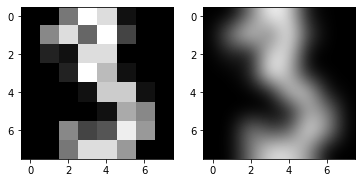

In [140]:
img = images[3]
assert 2 == len( img.shape )
plt.figure ()
plt.gray ()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, interpolation ="nearest" )
axarr[1].imshow(img, interpolation ="bicubic")
plt.show ()


In [141]:
np.shape(images[3])

(8, 8)

In [142]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test =\
model_selection.train_test_split( digits .data , digits . target , test_size = 0.4 , random_state = 0)


In [143]:
np.shape(X_train)

(1078, 64)

### 3.2 Distance function computation using loops

In [144]:
def dist_loop(training, test):
    
    dist = np.empty((np.shape(training)[0],np.shape(test)[0]))
    
    for i in range(np.shape(test)[0]): 
        
        for j in range(np.shape(training)[0]):
    
            dist[j][i] = np.sqrt(np.sum(np.square(np.subtract(training[j],test[i]))))         #distance function is the 1D Eucldiean distance
    
    return dist


In [145]:
#calculate distancematrix with loop function
a = dist_loop(X_train,X_test)
print(a)
np.shape(a)

[[55.67764363 53.12249994 56.56854249 ... 54.91812087 50.76416059
  46.87216658]
 [47.51841748 45.65084884 48.72371086 ... 45.475268   52.10566188
  40.18706259]
 [45.54119015 53.72150407 45.07771068 ... 44.96665431 50.8625599
  41.53311931]
 ...
 [46.         45.54119015 46.28174586 ... 51.32250968 44.62062303
  48.61069841]
 [44.98888752 49.07137659 53.55371136 ... 57.91372894 27.80287755
  40.28647416]
 [44.77722635 41.07310556 40.31128874 ... 43.78355856 52.
  44.22668877]]


(1078, 719)

### 3.3 Distance Function computation using vectorization

In [146]:
#Vectorized Distance Function

def dist_vec(training,test):
    """
    Distance function for arbitrary training set size N and test Set size M.
    
    params
    ------
    test : np.array shape=(M, D)
            test set for the classifier.
    training : np.array shape=(N, D)
        Training data for the classifier. 
    
    returns
    -------
    dist: np.array shape=(N,M)
        euclidean distance between [0,..,N] training point and [0,...,M] test point
    """
    
    #array with shape (M,N.D) and has N times the same D-dim testset under itself
    test_arr = np.transpose(np.full((np.shape(training)[0],np.shape(test)[0],np.shape(test)[1]),test),(1,0,2))
    
    #array with shape (M,N,D) and has M times the training array under itself
    training_arr = np.full((np.shape(test)[0],np.shape(training)[0],np.shape(training)[1]),training)
    
    #by subtracting from each other and taking the sum along the D-dim. axis we get an MxN matrix
    dist = np.sqrt(np.sum(np.square(np.subtract(test_arr,training_arr)),axis=2))
    
    #its transposed is the given NxM matrix from above
    return dist.T

In [147]:
#calculate distance matrix with vectorized function
b = dist_vec(X_train,X_test)

#compare both
print(a==b)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [148]:
#compare computation time of vectorized function with loop function
print("Time of vectorized function:")
%timeit dist_vec(X_train,X_test)
print("Time of loop function:")
%timeit dist_loop(X_train,X_test)

Time of vectorized function:
1 loop, best of 3: 400 ms per loop
Time of loop function:
1 loop, best of 3: 6.56 s per loop


Another, more cheaty way, is to use the scipy function `cdist`:

In [149]:
import scipy
from scipy import spatial
%timeit scipy.spatial.distance.cdist(X_train,X_test)

# Show that they are equal
c = scipy.spatial.distance.cdist(X_train,X_test)
print(a==c)

10 loops, best of 3: 33.4 ms per loop
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### 3.4 Nearest Neighbor

In [150]:
# k-nearest neighbour classifier for arbitrary training set size
def nn_classifier(k, x_test, x_train, y_train):
    """
    k-nearest neighbor classifier for arbitrary training set size N.
    
    params
    ------
    x_test : np.array shape=(1, 64)
        A single sample to classify.
    x_train : np.array shape=(N, 64)
        Training data for the classifier. 
    y_train: np.array shape=(10)
        Digits from 0 to 9.
    
    returns
    -------
    number: [0, 1, ..., 9]
        Predicted number of the x_test sample.
        Prediction by output of the most probable
        variant.
    """
    # Calculate "distances" to all training samples
    diff = scipy.spatial.distance.cdist(x_test, x_train)
    # Find the indices of the k nearest neighbors
    idx = np.argpartition(diff[0], k)[:k]
    # Find to which number they correspond
    numbers = y_train[idx]
    # Output the most probable number
    return np.bincount(numbers).argmax()

We want to distinguish the digit 3 from the digit 9. To do so, we take the union of `X_train_3` and `X_train_9` as our training set.

In [151]:
# Create data sets with only digit 3
X_test_3 = X_test[np.argwhere(y_test == 3)]
X_train_3 = X_train[np.argwhere(y_train == 3)]
X_train_3.reshape((len(X_train_3), 64))
y_train_3 = 3 * np.ones(len(X_train_3))

# Create data sets with only digit 9
X_test_9 = X_test[np.argwhere(y_test == 9)]
X_train_9 = X_train[np.argwhere(y_train == 9)]
X_train_9.reshape((len(X_train_9), 64))
y_train_9 = 9 * np.ones(len(X_train_9))

X_train_new = np.append(X_train_3, X_train_9).reshape((len(X_train_3)+len(X_train_9), 64))
y_train_new = np.append(y_train_3, y_train_9).astype(int)

In [152]:
# Calculate the error rate

def error_rate(k, digit, test_set, train_set, y_train):
  error = 0
  for i in range(len(test_set)):
    if nn_classifier(k, test_set[i], train_set, y_train) != digit:
      error += 1
  return error / len(test_set)

In [153]:
# Make this experiment 100 times and calculate average error and standard deviation:


def standard_deviation(k, digit, test_set, train_set, y_train):
  errors = np.empty(100)
  for i in range(100):
    errors[i] = error_rate(k, digit, test_set, train_set, y_train)
  return [np.average(errors), np.std(errors)]

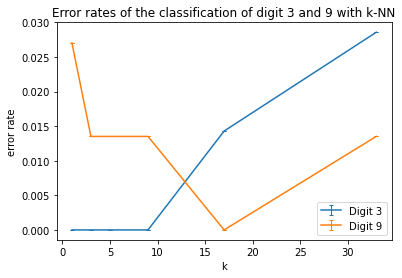

In [154]:
# Plot the error rates with errors

k = [1, 3, 5, 9, 17, 33]

errors3 = []
std3 = []

errors9 = []
std9 = []

for i in k:
  errors3.append(standard_deviation(i, 3, X_test_3, X_train_new, y_train_new)[0])
  errors9.append(standard_deviation(i, 9, X_test_9, X_train_new, y_train_new)[0])
  std3.append(standard_deviation(i, 3, X_test_3, X_train_new, y_train_new)[1])
  std9.append(standard_deviation(i, 9, X_test_9, X_train_new, y_train_new)[1])

plt.title("Error rates of the classification of digit 3 and 9 with k-NN")
plt.errorbar(k, errors3, yerr=std3, fmt="-", elinewidth=1, capsize=2, capthick=1, markersize=5, label="Digit 3")
plt.errorbar(k, errors9, yerr=std9, fmt="-", elinewidth=1, capsize=2, capthick=1, markersize=5, label="Digit 9")
plt.xlabel("k")
plt.ylabel("error rate")
plt.legend()
plt.show()

## 4. Cross-Validation

In [155]:
def split_folds(data, target, L):
    """
    split data and target sets into L folds of approx. equal size
    
    params
    ------
    data : np.array shape=(N, D)
            with N the size of the data set and D the number of features
    target : np.array shape=(N, 1)
            corresponding classified solutions of the dataset
    L : number of folds, which should be generated
    
    returns
    -------
    X_folds = np.array shape = (L,N/L,D)
            L equally sized data sets
    Y_folds = np.array shape = (L,N/L,1)
            corresponding L equally sized target sets
    """
    
    #define empty arrays and permutations of length N
    X_folds, Y_folds = np.empty(L), np.empty(L)
    data_split = []
    target_split = []
    permutations = np.array_split(np.random.permutation(np.shape(data)[0]),L)
    
    for i in permutations:
        data_split.append(data[i])
        target_split.append(target[i])

    return data_split, target_split

In [156]:
# Calculate the error rate

def error_rate_new(k, X_train, Y_train, X_test, Y_test):
  error = 0
  for i in range(np.shape(X_test)[0]):
    if nn_classifier(k, X_test[i], X_train, Y_train) != Y_test[i]:
      error += 1
  return error / len(test_set)

In [157]:
L = [2,5,10]

data_3_9  = data[np.argwhere(np.logical_or(target == 3,target == 9))]
target_3_9  = target[np.argwhere(np.logical_or(target == 3,target == 9))]


We didn't finish the task. Cross-validation is performed in the next exercise sheet.